In [1]:
import pandas as pd
import cluj_tools

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

from secrets import *

### Get Rosters

In [3]:
matchup_end_date, matchupPeriod = matchup_end_date()

TypeError: 'datetime.date' object is not callable

In [48]:
rosters = ct.get_rosters(matchupPeriod)

In [50]:
rosters.head()

,fullName,teamId
0,Marvin Bagley III,4
1,Kristaps Porzingis,4
2,Pascal Siakam,4
3,Lonzo Ball,4
4,Joel Embiid,4


### Get Boxscore data to calculate octys

In [4]:
dbname = 'cluj'
engine = create_engine('postgres://%s:%s@localhost/%s'%(AUTH['db_user'],AUTH['db_pass'],dbname))

if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


In [5]:
sql = """
    SELECT * FROM boxscores b
    LEFT JOIN player_name_comparison c ON b.name = c.boxscore_name
    WHERE b.season_year = '2019-2020' AND b.season_type = 'regular'
"""

In [6]:
boxscores = pd.read_sql(sql, engine)
boxscores['ft_pct'] = boxscores.ftm/boxscores.fta
boxscores['fg_pct'] = boxscores.fgm/boxscores.fga

In [16]:
boxscores.loc[boxscores.espn_name.isnull(),'espn_name'] = boxscores.loc[boxscores.espn_name.isnull(),'name']

In [19]:
ft_pct_threshold = 0.75
fg_pct_threshold = 0.4
octys = boxscores.loc[(boxscores.assists > 0) & (boxscores.threes > 0) & (boxscores.steals > 0) & (boxscores.rebounds > 0) & (boxscores['blocks'] > 0) & (boxscores.ft_pct > ft_pct_threshold) & (boxscores.fg_pct > fg_pct_threshold)]
octys.shape

(410, 21)

In [20]:
octy_counts = pd.DataFrame(octys.espn_name.value_counts())
octy_counts.reset_index(inplace=True)
octy_counts.rename(columns={'espn_name':'octy_count', 'index':'espn_name'}, inplace=True)

In [22]:
octys_games = pd.DataFrame(boxscores.groupby('espn_name')['assists'].count())
octys_games.reset_index(inplace=True)
octys_games.rename(columns={'assists':'game_count'}, inplace=True)

In [31]:
merged = octy_counts.merge(octys_games, on='espn_name')
merged['octy_pct'] = merged.octy_count / merged.game_count
merged.sort_values('octy_pct', ascending=False, inplace=True)
merged.shape

(177, 4)

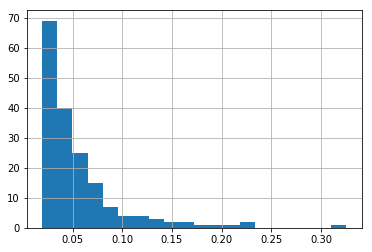

In [32]:
merged.octy_pct.hist(bins=20)

In [33]:
merged.head()

,espn_name,octy_count,game_count,octy_pct
0,Anthony Davis,14,43,0.325581
2,Kawhi Leonard,9,39,0.230769
1,James Harden,11,49,0.224490
3,Joel Embiid,8,37,0.216216
24,Kyrie Irving,4,20,0.200000


In [35]:
rosters_merge = merged.merge(rosters, left_on='espn_name', right_on='fullName', how='left')
rosters_merge.shape

(177, 6)

In [39]:
rosters_merge.groupby('teamId')['octy_pct'].mean()

teamId
1.0     0.043821
2.0     0.054696
3.0     0.060117
4.0     0.105404
5.0     0.079361
6.0     0.066162
7.0     0.078961
8.0     0.072280
9.0     0.056361
10.0    0.069635
11.0    0.057966
12.0    0.051272
Name: octy_pct, dtype: float64

In [40]:
rosters_merge.groupby('teamId')['octy_count'].sum()

teamId
1.0     18
2.0     18
3.0     27
4.0     44
5.0     35
6.0     26
7.0     31
8.0     24
9.0     24
10.0    35
11.0    24
12.0    17
Name: octy_count, dtype: int64

In [43]:
rosters_merge.loc[rosters_merge.teamId == 10]

,espn_name,octy_count,game_count,octy_pct,fullName,teamId
8,Josh Richardson,6,39,0.153846,Josh Richardson,10.0
11,Nikola Jokic,7,52,0.134615,Nikola Jokic,10.0
15,Myles Turner,5,42,0.119048,Myles Turner,10.0
28,Miles Bridges,4,51,0.078431,Miles Bridges,10.0
57,Maxi Kleber,3,51,0.058824,Maxi Kleber,10.0
79,Derrick Rose,2,44,0.045455,Derrick Rose,10.0
80,Matisse Thybulle,2,45,0.044444,Matisse Thybulle,10.0
85,Giannis Antetokounmpo,2,47,0.042553,Giannis Antetokounmpo,10.0
106,Justin Holiday,2,52,0.038462,Justin Holiday,10.0
112,Elfrid Payton,1,33,0.030303,Elfrid Payton,10.0


In [42]:
# should only be players on waiver wire
rosters_merge.loc[rosters_merge.fullName.isnull()].sort_values('octy_pct', ascending=False).head(15)

,espn_name,octy_count,game_count,octy_pct,fullName,teamId
19,Kadeem Allen,1,10,0.100000,NaN,NaN
22,Jonathan Isaac,3,32,0.093750,NaN,NaN
23,Justise Winslow,1,11,0.090909,NaN,NaN
27,PJ Dozier,1,12,0.083333,NaN,NaN
29,Mikal Bridges,4,52,0.076923,NaN,NaN
43,Jabari Parker,2,32,0.062500,NaN,NaN
44,Josh Okogie,3,48,0.062500,NaN,NaN
46,Alec Burks,3,48,0.062500,NaN,NaN
61,Derrick Jones Jr,2,37,0.054054,NaN,NaN
64,Cameron Johnson,2,39,0.051282,NaN,NaN
